In [2]:
import numpy as np
import sys
sys.path.append('..')
from lib.download import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tslearn.clustering import silhouette_score
import math

In [3]:
from scipy.stats.mstats import winsorize

In [4]:
market_data = load_all_closing_prices()

100%|██████████| 308/308 [00:13<00:00, 23.67it/s]


In [5]:
#[market_data.index.year>2021]
data_22_23 = market_data[market_data.index.year>2021]
filtered_data_22_23_returns = data_22_23.loc[:, 1-data_22_23.isna().sum()/len(data_22_23) >= 0.95].bfill().pct_change().iloc[1:,:]
filtered_data_22_23_ticker_as_feature = filtered_data_22_23_returns.T

In [6]:
def pca_df(df, n_components):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    pca = PCA(n_components = n_components)
    pca.fit(scaled)
    eig_val, eig_ratio = pca.explained_variance_, pca.explained_variance_ratio_ 
    df_pca = pd.DataFrame(pca.transform(df), index =df.index)
    print(f"Keyser : {len(eig_val[eig_val > 1])}, Actual E.V. ratio : {np.round(eig_ratio.cumsum()[-1:][0]*100,2)}")
    return df_pca 

def get_elbow_curve(df, min_clusters, max_clusters):
    inertia = np.array([])
    silhouette= np.array([])
    for k in tqdm(range(min_clusters, max_clusters)):
        KM = KMeans(n_clusters=k, n_init=10, random_state=8).fit(df)
        inertia = np.append(inertia, KM.inertia_)
        silhouette = np.append(silhouette, silhouette_score(df, KM.labels_, metric='euclidean'))
    plt.plot(range(min_clusters,max_clusters),inertia)
    plt.show()
    plt.plot(range(min_clusters,max_clusters),silhouette)
    plt.show()
    return inertia, silhouette

def get_labels(df, n_clust):
    cluster_labels = KMeans(n_clusters=n_clust, n_init=10, random_state = 8).fit(df)#.iloc[:,-lookback:])
    print(f"inertia : {silhouette_score(df, cluster_labels.labels_, metric='euclidean')}")
    cluster_labels = pd.Series(cluster_labels.labels_, index = df.index)
    return cluster_labels

def print_cluster_results(cluster_labels, filtered_data_22_23_returns, market_metrics):
    market_returns_cumsum = filtered_data_22_23_returns.cumsum().T
    market_returns = filtered_data_22_23_returns.T
    n_clusters = (cluster_labels.value_counts() > 1).value_counts()[1]
    n_graphs_per_line = 3
    n_lines = math.ceil(n_clusters/n_graphs_per_line)
    fig, axs = plt.subplots(n_lines, n_graphs_per_line, figsize=(20, n_clusters))
    k = 0
    clust = cluster_labels.value_counts()[cluster_labels.value_counts() > 1].sort_index().index
    average_returns = pd.DataFrame()
    for i in range(n_lines):
        for j in range(n_graphs_per_line):
            if k < n_clusters:
                if len(market_returns_cumsum[cluster_labels == clust[k]].index) > 1:
                    cluster_data = market_returns_cumsum[cluster_labels == clust[k]].T
                    cluster_returns = market_returns[cluster_labels == clust[k]].T
                    average_returns[clust[k]] = cluster_returns.mean(axis=1)
                    axs[i][j].plot(cluster_data)
                    axs[i][j].set_title('Stock Time Series for Cluster %d' % clust[k])

                k += 1

    fig.tight_layout()
    plt.show()

    return average_returns

In [7]:
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.stats as st


def calculate_cluster_metrics(cluster_labels, filtered_data_22_23_returns, market_metrics):
    market_returns_cumsum = filtered_data_22_23_returns.cumsum().T
    market_returns = filtered_data_22_23_returns.T
    n_clusters = (cluster_labels.value_counts() > 1).value_counts()[1]
    clust = cluster_labels.value_counts()[cluster_labels.value_counts() > 1].sort_index().index
    average_returns = pd.DataFrame()
    cluster_metrics = {}
    
    for k in range(n_clusters):
        if len(market_returns_cumsum[cluster_labels == clust[k]].index) > 1:
            cluster_returns = market_returns[cluster_labels == clust[k]].T
            average_returns[clust[k]] = cluster_returns.mean(axis=1)
            cluster_avg_return = average_returns[clust[k]]

            num_positive_returns = (cluster_avg_return > 0).sum()
            num_negative_returns = (cluster_avg_return < 0).sum()
            avg_positive_returns = cluster_avg_return[cluster_avg_return > 0].mean() * 100
            avg_negative_returns = cluster_avg_return[cluster_avg_return < 0].mean() * 100

            # Annualized return
            annual_return = (1 + cluster_avg_return.mean())**(365*24) - 1

            # Volatility measures
            total_volatility = cluster_avg_return.std() * (365*24)**0.5
            downside_volatility = cluster_avg_return[cluster_avg_return < 0].std() * (365*24)**0.5

            # Sharpe and Sortino ratios
            sharpe_ratio = annual_return / total_volatility if total_volatility else np.nan
            sortino_ratio = annual_return / downside_volatility if downside_volatility else np.nan

            # Calculate 95% confidence interval
            positive_ci = st.t.interval(alpha=0.95, df=len(cluster_avg_return[cluster_avg_return > 0])-1, loc=avg_positive_returns, scale=st.sem(cluster_avg_return[cluster_avg_return > 0]))
            negative_ci = st.t.interval(alpha=0.95, df=len(cluster_avg_return[cluster_avg_return < 0])-1, loc=avg_negative_returns, scale=st.sem(cluster_avg_return[cluster_avg_return < 0]))

            metrics = {
                'num_positive_returns': num_positive_returns,
                'num_negative_returns': num_negative_returns,
                'avg_positive_returns': avg_positive_returns,
                'avg_positive_returns_market_diff': avg_positive_returns - market_metrics['avg_positive_returns'] * 100,
                'avg_positive_returns_ci': positive_ci,
                'avg_negative_returns': avg_negative_returns,
                'avg_negative_returns_market_diff': avg_negative_returns - market_metrics['avg_negative_returns'] * 100,
                'avg_negative_returns_ci': negative_ci,
                'annual_return': annual_return,
                'total_volatility': total_volatility,
                'downside_volatility': downside_volatility,
                'sharpe_ratio': sharpe_ratio,
                'sortino_ratio': sortino_ratio
            }

            cluster_metrics[clust[k]] = metrics

    return cluster_metrics, average_returns



def plot_cluster_results(cluster_labels, filtered_data_22_23_returns):
    market_returns_cumsum = filtered_data_22_23_returns.cumsum().T
    n_clusters = (cluster_labels.value_counts() > 1).value_counts()[1]
    n_graphs_per_line = 3
    n_lines = math.ceil(n_clusters/n_graphs_per_line)
    fig, axs = plt.subplots(n_lines, n_graphs_per_line, figsize=(20, n_clusters))
    k = 0
    clust = cluster_labels.value_counts()[cluster_labels.value_counts() > 1].sort_index().index

    for i in range(n_lines):
        for j in range(n_graphs_per_line):
            if k < n_clusters:
                if len(market_returns_cumsum[cluster_labels == clust[k]].index) > 1:
                    cluster_data = market_returns_cumsum[cluster_labels == clust[k]].T
                    axs[i][j].plot(cluster_data)
                    axs[i][j].set_title('Stock Time Series for Cluster %d' % clust[k])

                k += 1

    fig.tight_layout()
    plt.show()


In [8]:
import scipy
risk_free_rate = 0
market_metrics = {
    'avg_positive_returns': 0.007344675309903409,
    'avg_negative_returns': -0.007844849392647865,
    'sharpe_ratio': -0.9914547482800211,
    'sortino_ratio': -1.2897748883665034
}

inertia : 0.1505001073812811


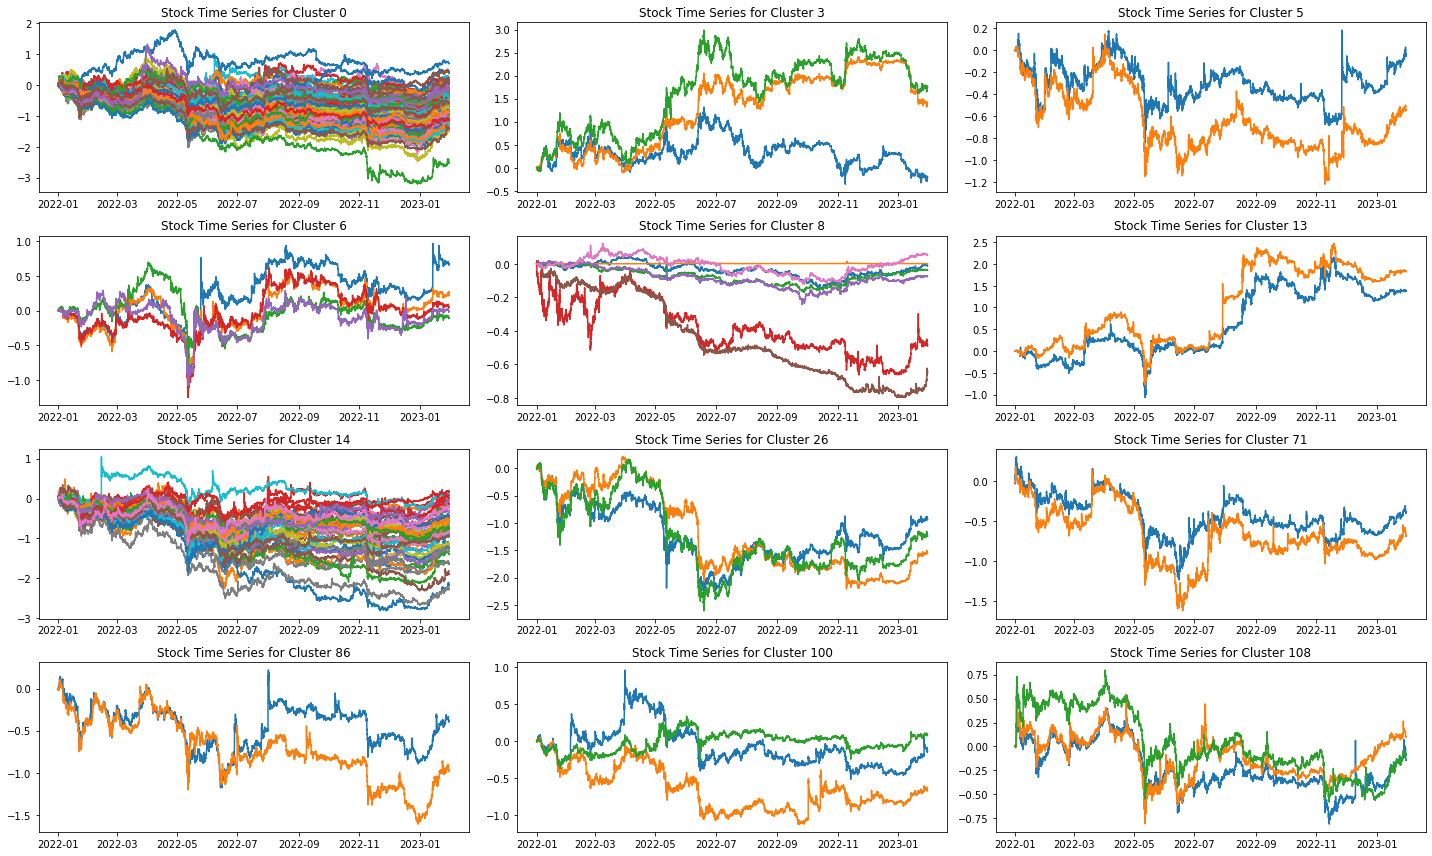

In [10]:
labls = get_labels(pca_dff, 109)

# Compute and print cluster results
average_returns= print_cluster_results(labls, filtered_data_22_23_returns, market_metrics)

In [11]:
labls[labls==5]

COCOSUSDT    5
COSUSDT      5
dtype: int32

In [46]:
cluster_metrics, average_returns = calculate_cluster_metrics(labls, filtered_data_22_23_returns, market_metrics)

Keyser : 120, Actual E.V. ratio : 70.77


100%|██████████| 175/175 [03:15<00:00,  1.12s/it]


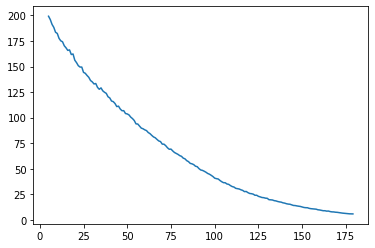

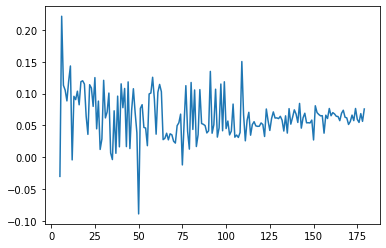

[  6 109  11  91  58  25  30  18  10  17  99  44  80  40  19  97  62  22
   7  77  23  42  47  94  85  82   8  15  63  61  57  33  56  38  13  59
  14   9  27 142 104  52  16 151  24  41  51 174 159 136 179 123 139 167
  46  36 127  32 113  48]


In [9]:
min_c, max_c = 5, 180
pca_dff=pca_df(filtered_data_22_23_ticker_as_feature,120)
inn, sii = get_elbow_curve(pca_dff, min_c, max_c)
print(np.argsort(sii)[::-1][:60]+min_c)

In [12]:
labls

1INCHUSDT      0
AAVEUSDT       0
ACHUSDT        5
ACMUSDT        4
ADADOWNUSDT    2
              ..
YGGUSDT        0
ZECUSDT        0
ZENUSDT        0
ZILUSDT        0
ZRXUSDT        0
Length: 292, dtype: int32

In [ ]:
avg_trends.cumsum().plot()

In [ ]:
tt avec ecart types, min-max, sortino, sharpe, cvar, rendement moyen, nbr de rentab positives, nombre de rentab negatives, moyenne des rentab positives, moyenne des rentab negatives, drawdown, top performers, correl avec autres clusters

In [ ]:
"Le cluster 1 a un rendement moyen de x% avec un écart type de y%. Le ratio de Sharpe est de z, ce qui indique une bonne/mauvaise performance ajustée au risque. La proportion de rendements positifs est de a%, et le drawdown maximum a été de b%. Les points forts de ce cluster comprennent c, d, e, tandis que les points faibles comprennent f, g, h."

In [ ]:
sharpe sur winsorajouter le rolling cluster pour la predictio n algorithmique et la diversification, ajouter la courbe moyenne du cluster et ses metriques winsor

In [ ]:
avoir les meilleurs performers des clusters

In [ ]:
filtered_data_22_23_returns

In [ ]:
distribution des sharpes ratio

In [ ]:
essayer avec un groupby par jour pr voir si cest aussi efficace